# Trabalho ACII

### Bibliotecas utilizadas

In [1]:
import pandas as pd
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import seaborn as sns
import IPython.display as ipd
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

### Apresentação do dataset original

In [2]:
df = pd.read_csv('C:/Users/andre/Documents/Faculdade/3ano_1sem/ACII/UrbanSound8K/metadata/UrbanSound8K.csv')
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


#### Aqui optamos por fazer uma lista com as labels de modo a posteriormente utilizarmos para fazer o training e test set

In [4]:
for coluna in df.columns:
    i=coluna
    labels = df[i].tolist()
    print(coluna)
print(labels)

slice_file_name
fsID
start
end
salience
fold
classID
class
['dog_bark', 'children_playing', 'children_playing', 'children_playing', 'children_playing', 'children_playing', 'children_playing', 'children_playing', 'children_playing', 'car_horn', 'car_horn', 'car_horn', 'car_horn', 'car_horn', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'air_conditioner', 'dog_bark', 'dog_bark',

### Distribuição das classes

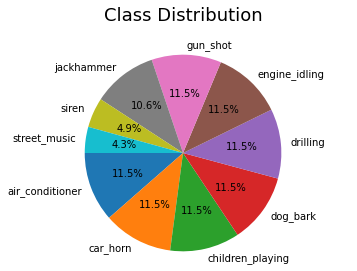

In [5]:
class_dict = df['class'].value_counts(normalize=True)
classes = list(np.unique(df['class']))
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(class_dict, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.savefig("distribution_class")
plt.show(block=False)

### Função para padronizar o aúdio de modo a todos terem 4 segundos

In [6]:
# Função para comprimir ou estender o áudio para 4 segundos
def adjust_audio_duration(audio_path, target_duration=4.0):
    y, sr = librosa.load(audio_path, sr=None)  # Carrega o arquivo de áudio

    # Calcula a duração atual do áudio
    current_duration = librosa.get_duration(y=y, sr=sr)

    # Se a duração atual for menor que a meta, estende o áudio com zeros
    if current_duration < target_duration:
        y_adjusted = np.pad(y, (0, int((target_duration - current_duration) * sr)), 'constant')
    # Se a duração atual for maior que a meta, corta o áudio
    else:
        y_adjusted = y[:int(target_duration * sr)]

    return y_adjusted, sr

In [7]:
audio_folder = 'C:/Users/andre/Documents/Faculdade/3ano_1sem/ACII/UrbanSound8K/audio/fold1'

# Lista o conteúdo do diretório
audio_folder2 = os.listdir(audio_folder)

# Ordena os arquivos por número de forma ascendente
sorted_files = sorted(audio_folder2, key=lambda x: int(''.join(filter(str.isdigit, x))) if any(c.isdigit() for c in x) else float('inf'))
count=0
for item in sorted_files:
    print(item)
    count+=1
print(count)

7061-6-0-0.wav
7383-3-0-0.wav
7383-3-0-1.wav
7383-3-1-0.wav
9031-3-1-0.wav
9031-3-2-0.wav
9031-3-3-0.wav
9031-3-4-0.wav
14113-4-0-0.wav
14113-4-0-1.wav
15564-2-0-0.wav
15564-2-0-1.wav
15564-2-0-2.wav
17592-5-0-0.wav
17592-5-1-0.wav
17592-5-1-1.wav
17592-5-1-2.wav
17592-5-1-3.wav
17913-4-0-0.wav
17913-4-0-1.wav
17913-4-0-2.wav
17913-4-1-0.wav
17913-4-2-0.wav
19026-1-0-0.wav
21684-9-0-5.wav
21684-9-0-7.wav
22962-4-0-0.wav
22962-4-0-1.wav
22962-4-0-2.wav
24074-1-0-0.wav
24074-1-0-1.wav
24074-1-0-2.wav
24074-1-0-3.wav
24074-1-0-4.wav
24074-1-0-5.wav
24074-1-0-6.wav
24074-1-0-7.wav
24074-1-0-8.wav
24074-1-0-9.wav
26270-9-0-3.wav
30823-8-0-0.wav
31323-3-0-1.wav
31323-3-0-2.wav
31840-3-0-0.wav
31840-3-1-0.wav
40722-8-0-0.wav
40722-8-0-1.wav
40722-8-0-2.wav
40722-8-0-3.wav
40722-8-0-4.wav
40722-8-0-5.wav
40722-8-0-6.wav
40722-8-0-7.wav
40722-8-0-8.wav
43786-3-0-0.wav
43786-3-1-0.wav
43806-8-0-0.wav
44736-5-0-0.wav
44736-5-0-1.wav
46654-6-0-0.wav
46656-6-0-0.wav
46656-6-1-0.wav
46656-6-2-0.wav


### Impressão de alguns espectrogramas de modo a verificar se todos os aúdios têm 4 segundos

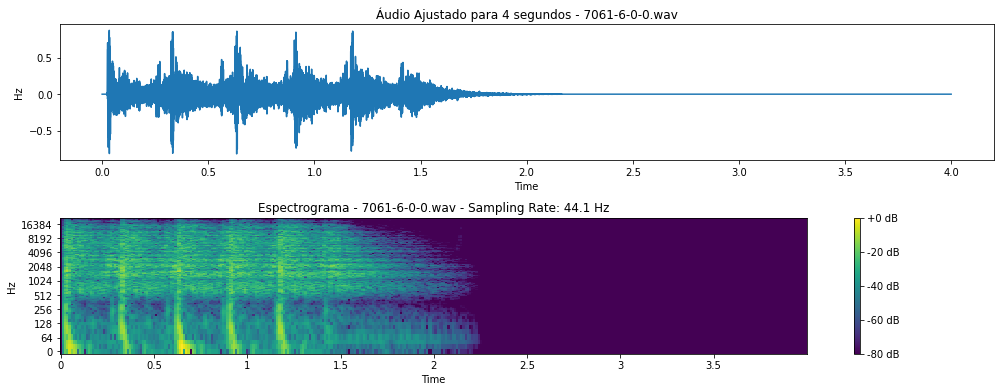

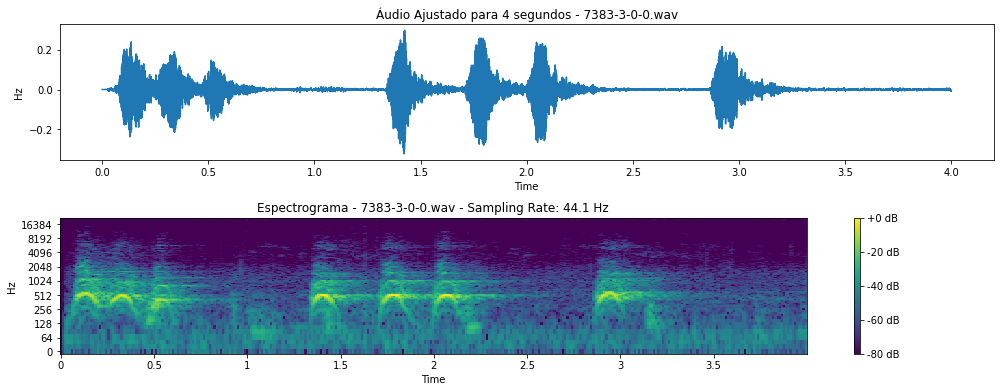

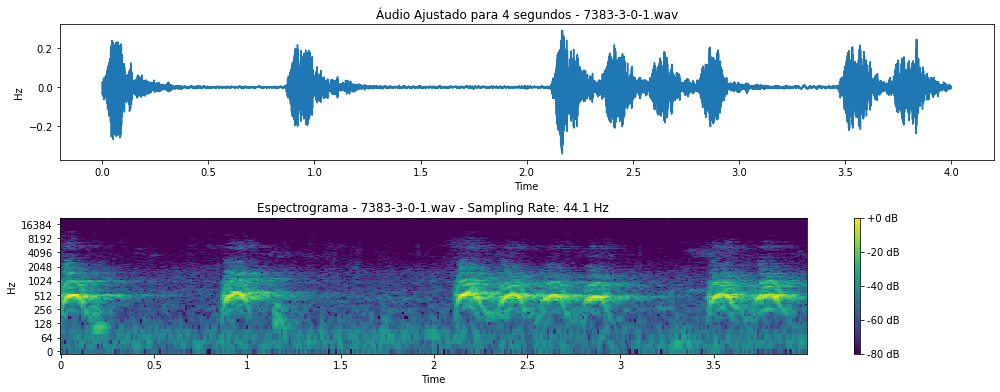

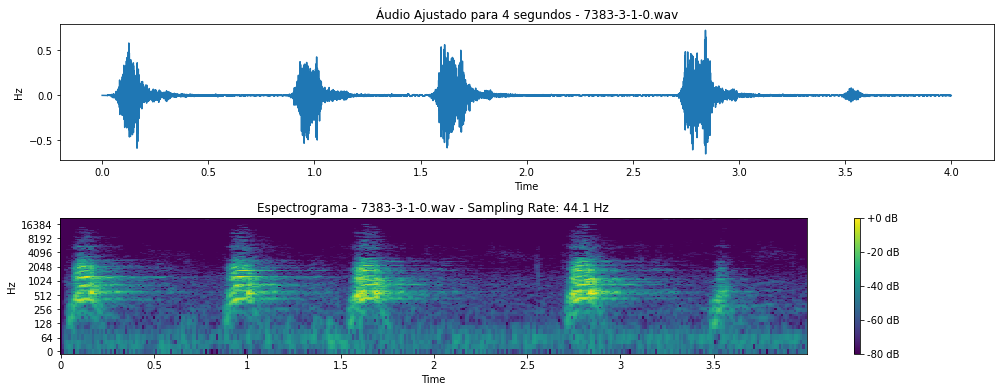

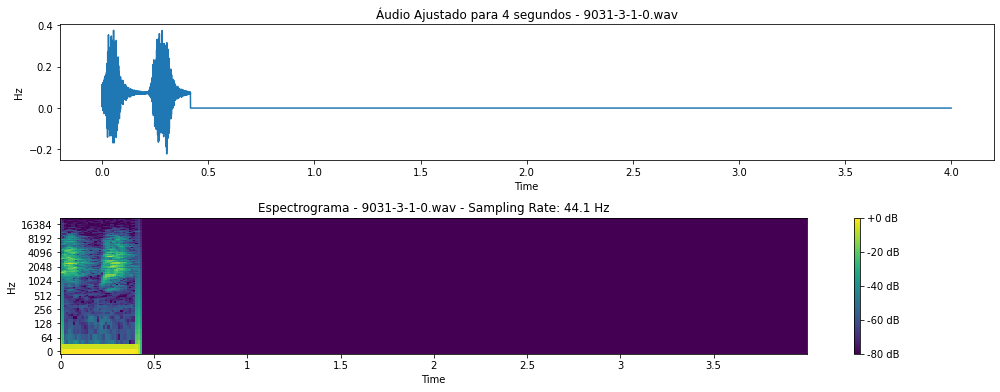

In [8]:
# Lista todos os arquivos na pasta e ordena por número de forma ascendente
audio_files = sorted([f for f in os.listdir(audio_folder) if f.endswith('.wav')], key=lambda x: int(''.join(filter(str.isdigit, x))) if any(c.isdigit() for c in x) else float('inf'))[:5]

# Itera sobre os arquivos ordenados
for filename in audio_files:
    if filename.endswith('.wav'):  # Certifique-se de que são arquivos de áudio WAV ou outro formato suportado
        audio_path = os.path.join(audio_folder, filename)
        
        # Ajusta o áudio para 4 segundos
        y_adjusted, sr = adjust_audio_duration(audio_path, target_duration=4.0)
        
        # Obtém a classe do áudio a partir do dataset
        # classe_do_audio = dataset.loc[dataset['classID'] == filename, 'class'].values[0]
    
        # Calcula o espectrograma
        spectrogram = np.abs(librosa.stft(y_adjusted))

        # Exibe o áudio ajustado, a forma de onda do áudio e o espectrograma
        plt.figure(figsize=(14, 8))

        plt.subplot(3, 1, 2)
        plt.plot(np.linspace(0, len(y_adjusted) / sr, num=len(y_adjusted)), y_adjusted)
        plt.title('Áudio Ajustado para 4 segundos - {}'.format(filename))
        plt.xlabel('Time')
        plt.ylabel('Hz')
        
        plt.subplot(3, 1, 3)
        librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr, cmap='viridis')
        plt.title('Espectrograma - {} - Sampling Rate: {} Hz'.format(filename,sr/1000))
        plt.colorbar(format='%+2.0f dB')
    
        plt.tight_layout()
        plt.show()
        ipd.display(ipd.Audio(y_adjusted, rate=sr))

### Função para extração das features usando a biblioteca librosa

In [8]:
def extract_features(audio_path, target_duration=4.0):
    # Carrega o áudio e ajusta a duração
    y, sr = librosa.load(audio_path, duration=target_duration)
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # Extrair as características do áudio
    
    #Spectral features
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    
    features = {
        'chroma_stft': np.mean(chroma_stft),
        'chroma_cqt': np.mean(chroma_cqt),
        'chroma_cens': np.mean(chroma_cens),
        'melspectrogram': np.mean(melspectrogram),
        'rms': np.mean(rms),
        'centroid': np.mean(spectral_centroid),
        'bandwidth': np.mean(spectral_bandwidth),
        'contrast': np.mean(spectral_contrast),
        'flatness': np.mean(spectral_flatness),
        'rolloff': np.mean(spectral_rolloff),
        'tonnetz' : np.mean(tonnetz),
        'zero_crossing_rate': np.mean(zero_crossing_rate),
        'poly_features' : np.mean(poly_features),
    }

    for i in range(1, 41):
        features[f'mcffs_{i}'] = np.mean(mfccs[i - 1])
        
    return features

In [9]:
# Estas características abrangem informações variadas do áudio, incluindo timbre (MFCCs e Chroma), aspectos temporais (onset strength), propriedades de amplitude (zero-crossing rate e RMSE), e propriedades espectrais (spectral flatness, spectral centroid e spectral bandwidth). A escolha dessas características pode variar dependendo do tipo de áudio e da tarefa de classificação que está sendo realizada. Experimente diferentes combinações de características e veja qual conjunto funciona melhor para o seu caso específico.

#### Função que percorre todas as pastas do dataset de modo a fazer a extração das features, criando um csv correspondente

In [10]:
def process_data (base_dir):
    for folder in os.listdir(base_dir):
        features_list = []
        label_list = []
        fold_dir = os.path.join(base_dir, folder)
        if os.path.isdir(fold_dir):
            for filename in os.listdir(fold_dir):
                file_path = os.path.join(fold_dir, filename)
                if filename.endswith('.wav'):
                    # Verifica se o arquivo está no DataFrame
                    row = df[df['slice_file_name'] == filename]
                    if not row.empty:
                        label = row['classID'].values[0]
                        features = extract_features(file_path)
                        features_list.append(features)
                        label_list.append(label)
        features_df=pd.DataFrame(features_list)
        features_df['Class'] = label_list
        features_df.to_csv('features'+folder+'.csv')
        print(features_df.head())
    return features_df
        

base_dir = 'C:/Users/andre/Documents/Faculdade/3ano_1sem/ACII/UrbanSound8K/audio'
urbansounds_df = process_data(base_dir)




C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=566
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=900
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=951
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=476
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=716
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=642
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=321
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=161
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=799
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=400
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=745
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=373
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=187
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=910
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=455
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=752
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=376
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=610
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=305
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=592
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=573
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=574
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=287
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=144
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=792
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.445801    0.559713     0.271074        3.025563  0.064127   
1     0.395806    0.561527     0.274245        2.735209  0.070910   
2     0.523600    0.612471     0.279564        1.727484  0.038650   
3     0.420314    0.554667     0.273006        0.281586  0.028449   
4     0.591936    0.663967     0.278611        0.223179  0.020878   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  1272.322596  1929.385330  21.229881  0.003123  2479.367859  ... -0.492060   
1  1091.849192  1661.472736  22.637942  0.001887  1851.108652  ... -1.524117   
2  1469.074963  2115.254016  19.706567  0.008064  2830.247048  ... -1.535643   
3  2280.391532  2262.256713  19.791382  0.032866  4217.020040  ... -1.704635   
4  1427.121009  2159.521180  18.934108  0.013790  2870.109194  ...  1.231341   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -3.183782  0.052147 -2.5222

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=447
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=224
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=724
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=362
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=662
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=683
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=621
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=311
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=156
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=634
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=317
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=159
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=597
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=676
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=990
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=495
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=248
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=811
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=406
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.353847    0.571239     0.280303        0.381205  0.041719   
1     0.483272    0.671517     0.285768        0.213664  0.031859   
2     0.351821    0.648673     0.279960        0.217073  0.039540   
3     0.497890    0.707808     0.284976        0.144776  0.027866   
4     0.352928    0.576470     0.266824        9.928281  0.194223   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  2244.903027  2582.639445  21.211227  0.015622  5062.225342  ... -1.202059   
1  2287.902165  2399.048101  21.648299  0.021644  4566.911515  ... -3.357098   
2  2658.458058  2435.765982  22.770216  0.020866  5074.658203  ...  2.216005   
3  2428.110524  2416.151425  21.278114  0.026887  4858.813477  ...  3.524665   
4  3234.695900  2700.758526  22.076756  0.031261  6726.733398  ... -0.172835   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38   mcffs_39  \
0 -2.044167  3.839334 -6.980

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=559
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=280
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=683
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=342
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=626
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=313
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=965
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=483
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=242
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=820
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=703
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=708
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=354
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=177
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=707
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=700
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=907
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=953
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=819
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=221
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=951
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=476
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=238
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=577
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=576
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=288
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=144
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=541
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=271
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.421035    0.596134     0.277365        1.100321  0.050663   
1     0.404458    0.588112     0.276284        1.182545  0.050825   
2     0.415571    0.595754     0.279878        1.089658  0.045925   
3     0.396457    0.557634     0.273136        1.700688  0.057532   
4     0.495882    0.665758     0.281093        0.167323  0.022238   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  2134.563996  1710.030818  20.951091  0.013501  3428.446899  ...  2.833068   
1  2092.131632  1582.580339  20.582664  0.011403  3173.035726  ...  1.185976   
2  2091.179247  1605.886534  20.255547  0.012868  3238.382152  ...  0.229474   
3  2014.319880  1499.496641  20.839413  0.009972  3060.888813  ... -0.969802   
4  2358.879985  2137.336626  17.830943  0.045022  4198.051758  ... -0.296388   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -2.623472  2.111799  0.4296

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=524
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=872
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=914
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=457
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=517
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=892
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=617
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=792
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=709
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=745
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=373
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=756
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=378
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=646
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=323
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=818
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=409
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=731
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=868
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=854
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=910
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=455
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=527
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.433149    0.600546     0.279427        0.170550  0.022765   
1     0.521690    0.668936     0.282055        2.038464  0.106494   
2     0.603787    0.665428     0.280408        3.143876  0.143156   
3     0.640937    0.639250     0.277068        3.517530  0.147511   
4     0.632808    0.638626     0.277802        3.446131  0.146118   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  2446.028613  2255.406678  18.803328  0.040394  4450.589466  ... -1.583593   
1  2659.554877  1949.577399  21.208879  0.023126  4206.816180  ...  3.390362   
2  2401.793477  1791.653465  21.014373  0.015758  3814.550922  ...  4.247619   
3  2286.545130  1770.464802  21.362692  0.014185  3675.767561  ...  4.251390   
4  2296.005793  1783.682922  21.391066  0.015546  3665.312133  ...  3.444574   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -3.407521  0.548497 -3.0207

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=816
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=552
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=276
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=676
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=338
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=813
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=407
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=204
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=822
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=411
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=965
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=366
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=799
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=400
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=533
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=655
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=328
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=490
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=722
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=361
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=893
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=447
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=224
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=869
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=435
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.458842    0.653919     0.283252        0.050471  0.013894   
1     0.230843    0.490274     0.264043        0.012908  0.006869   
2     0.402055    0.617801     0.277096        0.004098  0.004611   
3     0.248293    0.484140     0.266963        0.020077  0.009531   
4     0.553183    0.546464     0.271684        0.012856  0.008225   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  2284.820711  2202.102614  19.102446  0.034939  4110.913450  ...  0.487781   
1  2595.194674  2420.471017  21.110440  0.023919  5184.896586  ...  5.171669   
2  3005.433745  2565.850403  19.770565  0.071225  5829.087874  ...  2.468214   
3  2969.865530  2626.990236  20.981222  0.040964  5915.158451  ...  2.916133   
4  2419.997831  2173.467485  19.650331  0.036739  4707.805444  ... -1.144933   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -1.678727  1.410535 -1.7127

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=873
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=437
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=749
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=375
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=798
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=709
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=355
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=827
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=414
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=797
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=727
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=600
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=993
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=497
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=613
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=965
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=483
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=242
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=121
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=673
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.342925    0.523729     0.270312        4.515515  0.126444   
1     0.502187    0.704434     0.281023        0.002774  0.003993   
2     0.535061    0.682461     0.278783        0.001810  0.003006   
3     0.441757    0.603883     0.277310        0.004552  0.004653   
4     0.530755    0.556548     0.275156        0.001949  0.003216   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  2089.849953  1736.189528  21.621388  0.005708  2875.451660  ...  7.510886   
1  2137.808989  1971.446838  20.221480  0.011596  3996.089516  ...  2.277220   
2  1846.767527  1950.695683  19.649264  0.008446  3695.993836  ... -0.154539   
3  2301.066813  2262.904380  20.470861  0.020788  4502.928841  ...  1.279155   
4  2004.947175  1951.244545  19.610958  0.009969  3927.071244  ... -0.774089   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -0.885359  2.393814 -6.3923

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=603
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1020
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=510
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=255
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=903
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=965
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=483
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=242
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=121
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1019
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=583
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=292
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=765
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=383
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=561
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=556
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=278
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=249
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=125
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=955
  warnings.warn(


   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.559152    0.700408     0.285539        0.287792  0.036457   
1     0.534395    0.644574     0.283104        2.015125  0.100865   
2     0.544626    0.672565     0.285384        0.476941  0.050473   
3     0.625679    0.759648     0.285852        0.686631  0.058281   
4     0.507904    0.718919     0.284452        0.380082  0.042241   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  3574.630967  2578.230464  18.841002  0.103506  6657.369378  ...  3.109385   
1  3289.877463  2491.533016  19.058830  0.084920  6148.289604  ...  4.922350   
2  3194.741895  2358.003725  18.646189  0.076944  5686.943839  ...  4.407555   
3  2945.500877  2812.330965  17.911242  0.089349  6499.791140  ...  3.094439   
4  2541.069048  2648.799239  18.172173  0.051777  5690.242278  ...  3.134973   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -2.080568  2.165513 -3.8676

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=703
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=352
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=882
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=441
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=586
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=379
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=602
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=972
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=486
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=905
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=159
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=600
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=300
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=800
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=717
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=359
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=180
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=90
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=988
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\si

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.397373    0.424002     0.258243        0.551967  0.047048   
1     0.422297    0.418285     0.256499        0.525703  0.045951   
2     0.409198    0.427166     0.255655        0.498180  0.044939   
3     0.398596    0.449678     0.255650        0.573580  0.047667   
4     0.425841    0.493966     0.266249        0.410048  0.040159   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  1379.222280  1934.779394  21.841274  0.003653  2505.444195  ... -2.055787   
1  1372.665792  1930.772697  21.633497  0.003927  2497.229216  ... -2.525715   
2  1480.377737  2004.847751  22.084130  0.004507  2863.542607  ... -0.986494   
3  1374.669956  1899.050415  22.205454  0.003502  2634.021067  ...  0.788770   
4  1343.352316  1893.066544  20.572762  0.004433  2431.882790  ... -0.151675   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -2.061057  2.585048 -4.4026

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=871
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=668
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=334
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=621
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=311
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=388
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=638
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=836
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=418
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=590
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=969
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=485
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=882
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=907
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=561
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=920
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=802
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=702
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=564
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.298557    0.489533     0.265880        2.171478  0.043682   
1     0.249322    0.427730     0.252688        5.639101  0.089814   
2     0.292587    0.493539     0.264134        3.380812  0.073360   
3     0.466226    0.632482     0.278680        1.127314  0.073104   
4     0.463087    0.586579     0.277274        1.034284  0.069865   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  1366.653319  1776.833099  22.002282  0.003694  2214.956637  ...  0.539304   
1  1248.092141  1523.825254  22.384928  0.001976  1827.502441  ... -0.182392   
2  1198.050617  1489.821440  22.826544  0.001286  1733.422852  ... -0.753595   
3  2340.514287  2016.318796  19.949570  0.026422  4432.977048  ...  6.212684   
4  2444.639050  2157.429623  20.045069  0.032550  4695.109567  ...  8.288436   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -0.632341  1.068683  1.1267

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=793
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=397
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=379
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=971
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=486
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=562
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=648
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=324
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=579
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=290
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=145
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=73
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=825
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\si

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=909
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=688
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=344
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=169
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=552
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\s

   chroma_stft  chroma_cqt  chroma_cens  melspectrogram       rms  \
0     0.475005    0.671344     0.280346        0.635895  0.087440   
1     0.389542    0.606423     0.278319        0.688865  0.090911   
2     0.443765    0.601875     0.278630        0.713260  0.092560   
3     0.498970    0.615763     0.278120        0.678522  0.089096   
4     0.501920    0.611138     0.277630        0.577139  0.078671   

      centroid    bandwidth   contrast  flatness      rolloff  ...  mcffs_32  \
0  5065.193852  2938.446260  18.971361  0.108621  8847.470393  ...  3.212432   
1  4542.653223  2904.973014  20.078371  0.029818  8319.782447  ...  2.911234   
2  4902.830395  2930.293272  19.718682  0.067427  8710.429603  ...  2.915511   
3  5081.332822  2950.998007  19.477569  0.097678  8850.644362  ...  2.744623   
4  4657.044530  2960.616543  19.482536  0.067443  8445.620992  ...  2.305083   

   mcffs_33  mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_38  mcffs_39  \
0 -5.028516  3.729041 -3.8122

# Data pre-processing e implementação das neural networks


#### Standard scalling dos dados de treino e criação dos training e test sets

In [9]:
# Normalização dos Dados
def standard_scalling(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X = X_normalized
    
    return X

In [10]:
def load_fold_data(fold_file):
    fold = pd.read_csv(fold_file)
    
    # Assuming 'Class' is the column name for labels
    y = fold['Class'].values
    X = fold.drop(columns=['Class']).values
    
    # Normalização dos Dados
    X = standard_scalling(X)
    
    return X, y

# MLP

### Implementação da rede neuronal usando o tensorflow

In [86]:
def MLP(X_train, y_train, X_test, y_test, loss_plot=None, cmatrix=None, acc_plot=None):
    # Assuming X_train and X_test are 2D arrays (e.g., feature vectors)
    input_shape = X_train.shape[1:]  # Shape of each input sample

    num_classes = len(np.unique(y_train))

    # Ajuste o valor da learning rate conforme necessário
    learning_rate = 0.05
    
    # Crie um otimizador com a taxa de aprendizado desejada
    optimizer = SGD(learning_rate=learning_rate)

    # Build the MLP model
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    #keras.utils.plot_model(model, 'MLP.png', show_shapes=True)
    
    # Adicionar o Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile o modelo usando o otimizador personalizado
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8,6))
    plt.hist(y_pred, bins=10, alpha=0.7, color='blue', label='Predictions')
    plt.title('Distribution of Predictions')
    plt.ylabel('Frequency')
    plt.xlabel('Predicted labels')
    plt.legend()
    plt.show()
    
    # Confusion Matrix
    if cmatrix:
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.savefig(cmatrix)
        plt.close()
    
    
    # plot training history - loss
    if loss_plot:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend(['loss','test_loss'], loc='upper left')
        plt.savefig(loss_plot)
        plt.close()
        
    # plot training history for accuracy
    if acc_plot:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend(['accuracy','val_accuracy'], loc='upper left')
        plt.savefig(acc_plot)
        plt.close()
        
    

    return accuracy, model

    

### Aplicação da Cross Validation

Epoch 1/40
64/64 [==============================] - 2s 13ms/step - loss: 2.2895 - accuracy: 0.1400 - val_loss: 2.6624 - val_accuracy: 0.0310
Epoch 2/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1836 - accuracy: 0.2005 - val_loss: 2.5827 - val_accuracy: 0.1372
Epoch 3/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1171 - accuracy: 0.2462 - val_loss: 2.5574 - val_accuracy: 0.1726
Epoch 4/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0582 - accuracy: 0.2879 - val_loss: 2.5264 - val_accuracy: 0.2046
Epoch 5/40
64/64 [==============================] - 0s 7ms/step - loss: 1.9981 - accuracy: 0.3186 - val_loss: 2.4618 - val_accuracy: 0.2190
Epoch 6/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9433 - accuracy: 0.3256 - val_loss: 2.3962 - val_accuracy: 0.2102
Epoch 7/40
64/64 [==============================] - 0s 6ms/step - loss: 1.8901 - accuracy: 0.3507 - val_loss: 2.2624 - val_accuracy: 0.2467
Epoch 8/40
64/64 [=

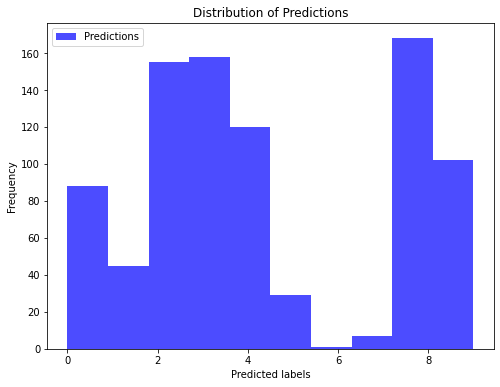

Epoch 1/40
64/64 [==============================] - 2s 13ms/step - loss: 2.2863 - accuracy: 0.1390 - val_loss: 2.7352 - val_accuracy: 0.0695
Epoch 2/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1862 - accuracy: 0.2034 - val_loss: 2.6830 - val_accuracy: 0.1125
Epoch 3/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1205 - accuracy: 0.2607 - val_loss: 2.6287 - val_accuracy: 0.1632
Epoch 4/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0528 - accuracy: 0.2958 - val_loss: 2.5771 - val_accuracy: 0.2095
Epoch 5/40
64/64 [==============================] - 0s 7ms/step - loss: 1.9904 - accuracy: 0.3126 - val_loss: 2.4089 - val_accuracy: 0.2161
Epoch 6/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9410 - accuracy: 0.3411 - val_loss: 2.3562 - val_accuracy: 0.2260
Epoch 7/40
64/64 [==============================] - 0s 6ms/step - loss: 1.8923 - accuracy: 0.3526 - val_loss: 2.3467 - val_accuracy: 0.2525
Epoch 8/40
64/64 [=

Epoch 1/40
64/64 [==============================] - 2s 13ms/step - loss: 2.2863 - accuracy: 0.1378 - val_loss: 2.6559 - val_accuracy: 0.0611
Epoch 2/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1801 - accuracy: 0.2089 - val_loss: 2.6605 - val_accuracy: 0.1067
Epoch 3/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1046 - accuracy: 0.2579 - val_loss: 2.5601 - val_accuracy: 0.1833
Epoch 4/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0364 - accuracy: 0.2959 - val_loss: 2.5086 - val_accuracy: 0.2278
Epoch 5/40
64/64 [==============================] - 0s 7ms/step - loss: 1.9721 - accuracy: 0.3204 - val_loss: 2.4705 - val_accuracy: 0.2156
Epoch 6/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9180 - accuracy: 0.3449 - val_loss: 2.3507 - val_accuracy: 0.2411
Epoch 7/40
64/64 [==============================] - 0s 6ms/step - loss: 1.8735 - accuracy: 0.3623 - val_loss: 2.3263 - val_accuracy: 0.2422
Epoch 8/40
64/64 [=

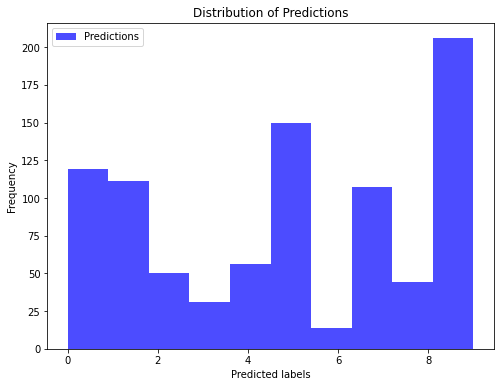

Epoch 1/40
64/64 [==============================] - 2s 12ms/step - loss: 2.2834 - accuracy: 0.1391 - val_loss: 2.6824 - val_accuracy: 0.0356
Epoch 2/40
64/64 [==============================] - 0s 6ms/step - loss: 2.1912 - accuracy: 0.2020 - val_loss: 2.6334 - val_accuracy: 0.1544
Epoch 3/40
64/64 [==============================] - 0s 6ms/step - loss: 2.1191 - accuracy: 0.2554 - val_loss: 2.5700 - val_accuracy: 0.1756
Epoch 4/40
64/64 [==============================] - 0s 6ms/step - loss: 2.0615 - accuracy: 0.2884 - val_loss: 2.4972 - val_accuracy: 0.2089
Epoch 5/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9959 - accuracy: 0.3181 - val_loss: 2.4382 - val_accuracy: 0.2211
Epoch 6/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9423 - accuracy: 0.3428 - val_loss: 2.4117 - val_accuracy: 0.2456
Epoch 7/40
64/64 [==============================] - 0s 7ms/step - loss: 1.8882 - accuracy: 0.3636 - val_loss: 2.2977 - val_accuracy: 0.2378
Epoch 8/40
64/64 [=

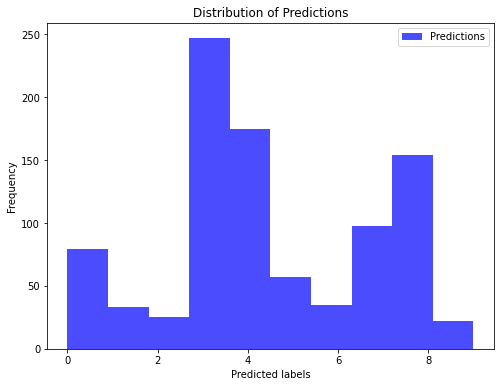

Epoch 1/40
64/64 [==============================] - 2s 14ms/step - loss: 2.2948 - accuracy: 0.1336 - val_loss: 2.7128 - val_accuracy: 0.0767
Epoch 2/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1938 - accuracy: 0.1946 - val_loss: 2.6831 - val_accuracy: 0.0856
Epoch 3/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1248 - accuracy: 0.2489 - val_loss: 2.5985 - val_accuracy: 0.1433
Epoch 4/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0586 - accuracy: 0.2930 - val_loss: 2.5810 - val_accuracy: 0.2056
Epoch 5/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0002 - accuracy: 0.3152 - val_loss: 2.4199 - val_accuracy: 0.2122
Epoch 6/40
64/64 [==============================] - 0s 7ms/step - loss: 1.9503 - accuracy: 0.3306 - val_loss: 2.3399 - val_accuracy: 0.2378
Epoch 7/40
64/64 [==============================] - 0s 7ms/step - loss: 1.8969 - accuracy: 0.3565 - val_loss: 2.3532 - val_accuracy: 0.2478
Epoch 8/40
64/64 [=

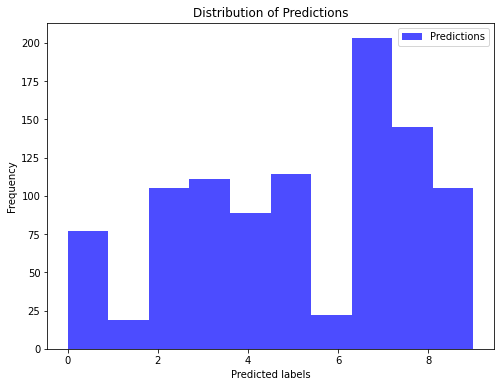

Epoch 1/40
64/64 [==============================] - 2s 13ms/step - loss: 2.2780 - accuracy: 0.1383 - val_loss: 2.7324 - val_accuracy: 0.0100
Epoch 2/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1871 - accuracy: 0.2043 - val_loss: 2.7795 - val_accuracy: 0.0522
Epoch 3/40
64/64 [==============================] - 0s 7ms/step - loss: 2.1248 - accuracy: 0.2488 - val_loss: 2.6592 - val_accuracy: 0.1044
Epoch 4/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0640 - accuracy: 0.2735 - val_loss: 2.5806 - val_accuracy: 0.1444
Epoch 5/40
64/64 [==============================] - 0s 7ms/step - loss: 2.0118 - accuracy: 0.2998 - val_loss: 2.4851 - val_accuracy: 0.1956
Epoch 6/40
64/64 [==============================] - 0s 7ms/step - loss: 1.9568 - accuracy: 0.3202 - val_loss: 2.5329 - val_accuracy: 0.1922
Epoch 7/40
64/64 [==============================] - 0s 6ms/step - loss: 1.9092 - accuracy: 0.3414 - val_loss: 2.2978 - val_accuracy: 0.2367
Epoch 8/40
64/64 [=

Epoch 1/40
66/66 [==============================] - 2s 13ms/step - loss: 2.2982 - accuracy: 0.1264 - val_loss: 2.7421 - val_accuracy: 0.1041
Epoch 2/40
66/66 [==============================] - 0s 7ms/step - loss: 2.1829 - accuracy: 0.2088 - val_loss: 2.6790 - val_accuracy: 0.1427
Epoch 3/40
66/66 [==============================] - 0s 6ms/step - loss: 2.0968 - accuracy: 0.2712 - val_loss: 2.5824 - val_accuracy: 0.1792
Epoch 4/40
66/66 [==============================] - 0s 6ms/step - loss: 2.0202 - accuracy: 0.3048 - val_loss: 2.5770 - val_accuracy: 0.1888
Epoch 5/40
66/66 [==============================] - 0s 6ms/step - loss: 1.9478 - accuracy: 0.3392 - val_loss: 2.5765 - val_accuracy: 0.2060
Epoch 6/40
66/66 [==============================] - 0s 6ms/step - loss: 1.8876 - accuracy: 0.3542 - val_loss: 2.5015 - val_accuracy: 0.2082
Epoch 7/40
66/66 [==============================] - 0s 7ms/step - loss: 1.8377 - accuracy: 0.3670 - val_loss: 2.4215 - val_accuracy: 0.2146
Epoch 8/40
66/66 [=

Epoch 1/40
65/65 [==============================] - 2s 14ms/step - loss: 2.2740 - accuracy: 0.1487 - val_loss: 2.6585 - val_accuracy: 0.0952
Epoch 2/40
65/65 [==============================] - 0s 7ms/step - loss: 2.1583 - accuracy: 0.2305 - val_loss: 2.6335 - val_accuracy: 0.1494
Epoch 3/40
65/65 [==============================] - 0s 7ms/step - loss: 2.0767 - accuracy: 0.2798 - val_loss: 2.6013 - val_accuracy: 0.1656
Epoch 4/40
65/65 [==============================] - 0s 6ms/step - loss: 2.0080 - accuracy: 0.3089 - val_loss: 2.5382 - val_accuracy: 0.2121
Epoch 5/40
65/65 [==============================] - 0s 7ms/step - loss: 1.9443 - accuracy: 0.3361 - val_loss: 2.4226 - val_accuracy: 0.2273
Epoch 6/40
65/65 [==============================] - 0s 7ms/step - loss: 1.8822 - accuracy: 0.3633 - val_loss: 2.4551 - val_accuracy: 0.2294
Epoch 7/40
65/65 [==============================] - 0s 7ms/step - loss: 1.8326 - accuracy: 0.3766 - val_loss: 2.3603 - val_accuracy: 0.2305
Epoch 8/40
65/65 [=

Epoch 1/40
65/65 [==============================] - 2s 13ms/step - loss: 2.2919 - accuracy: 0.1380 - val_loss: 2.6901 - val_accuracy: 0.1095
Epoch 2/40
65/65 [==============================] - 0s 7ms/step - loss: 2.1818 - accuracy: 0.2204 - val_loss: 2.6115 - val_accuracy: 0.1594
Epoch 3/40
65/65 [==============================] - 0s 6ms/step - loss: 2.1078 - accuracy: 0.2661 - val_loss: 2.5571 - val_accuracy: 0.1898
Epoch 4/40
65/65 [==============================] - 0s 6ms/step - loss: 2.0328 - accuracy: 0.3107 - val_loss: 2.5596 - val_accuracy: 0.1985
Epoch 5/40
65/65 [==============================] - 0s 7ms/step - loss: 1.9650 - accuracy: 0.3343 - val_loss: 2.4144 - val_accuracy: 0.2256
Epoch 6/40
65/65 [==============================] - 0s 7ms/step - loss: 1.9051 - accuracy: 0.3529 - val_loss: 2.3971 - val_accuracy: 0.2234
Epoch 7/40
65/65 [==============================] - 0s 7ms/step - loss: 1.8507 - accuracy: 0.3696 - val_loss: 2.2995 - val_accuracy: 0.2278
Epoch 8/40
65/65 [=

Epoch 1/40
65/65 [==============================] - 2s 13ms/step - loss: 2.2758 - accuracy: 0.1371 - val_loss: 2.6608 - val_accuracy: 0.0763
Epoch 2/40
65/65 [==============================] - 0s 6ms/step - loss: 2.1647 - accuracy: 0.2171 - val_loss: 2.5934 - val_accuracy: 0.1743
Epoch 3/40
65/65 [==============================] - 0s 6ms/step - loss: 2.0832 - accuracy: 0.2769 - val_loss: 2.5814 - val_accuracy: 0.1547
Epoch 4/40
65/65 [==============================] - 0s 6ms/step - loss: 2.0134 - accuracy: 0.3071 - val_loss: 2.5351 - val_accuracy: 0.2004
Epoch 5/40
65/65 [==============================] - 0s 6ms/step - loss: 1.9388 - accuracy: 0.3405 - val_loss: 2.4677 - val_accuracy: 0.2200
Epoch 6/40
65/65 [==============================] - 0s 6ms/step - loss: 1.8890 - accuracy: 0.3533 - val_loss: 2.3337 - val_accuracy: 0.2255
Epoch 7/40
65/65 [==============================] - 0s 7ms/step - loss: 1.8424 - accuracy: 0.3850 - val_loss: 2.2788 - val_accuracy: 0.2375
Epoch 8/40
65/65 [=

In [87]:
n_folds=10
scores = [] 
for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            fold_file = f'C:/Users/andre/Documents/Faculdade/3ano_1sem/ACII/UrbanSound8K/audio/featuresfold{fold}.csv'
            features, labels = load_fold_data(fold_file)

            if fold == test_fold:
                X_test, y_test = features, labels
            else:
                X_train.append(features)
                y_train.append(labels)
                
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        smote = SMOTE(random_state = 42)
        
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
        # Nome do arquivo incorporando o índice do test_fold
        lossplot_filename = f'mlp_lossplotfold{test_fold}.png'
        
        # Nome do arquivo incorporando o índice do test_fold
        accplot_filename = f'mlp_accplotfold{test_fold}.png'
        
        # Nome do arquivo incorporando o índice do test_fold
        cmatrix_filename = f'mlp_cmfold{test_fold}.png'
   
        accuracy, model = MLP(X_resampled, y_resampled, X_test, y_test, loss_plot=lossplot_filename, cmatrix = cmatrix_filename, acc_plot = accplot_filename)
        scores.append(accuracy)
        

In [88]:
model.summary()

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_112 (Flatten)       (None, 54)                0         
                                                                 
 dense_224 (Dense)           (None, 128)               7040      
                                                                 
 dropout_112 (Dropout)       (None, 128)               0         
                                                                 
 dense_225 (Dense)           (None, 10)                1290      
                                                                 
Total params: 8330 (32.54 KB)
Trainable params: 8330 (32.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Resultados da Cross Validation

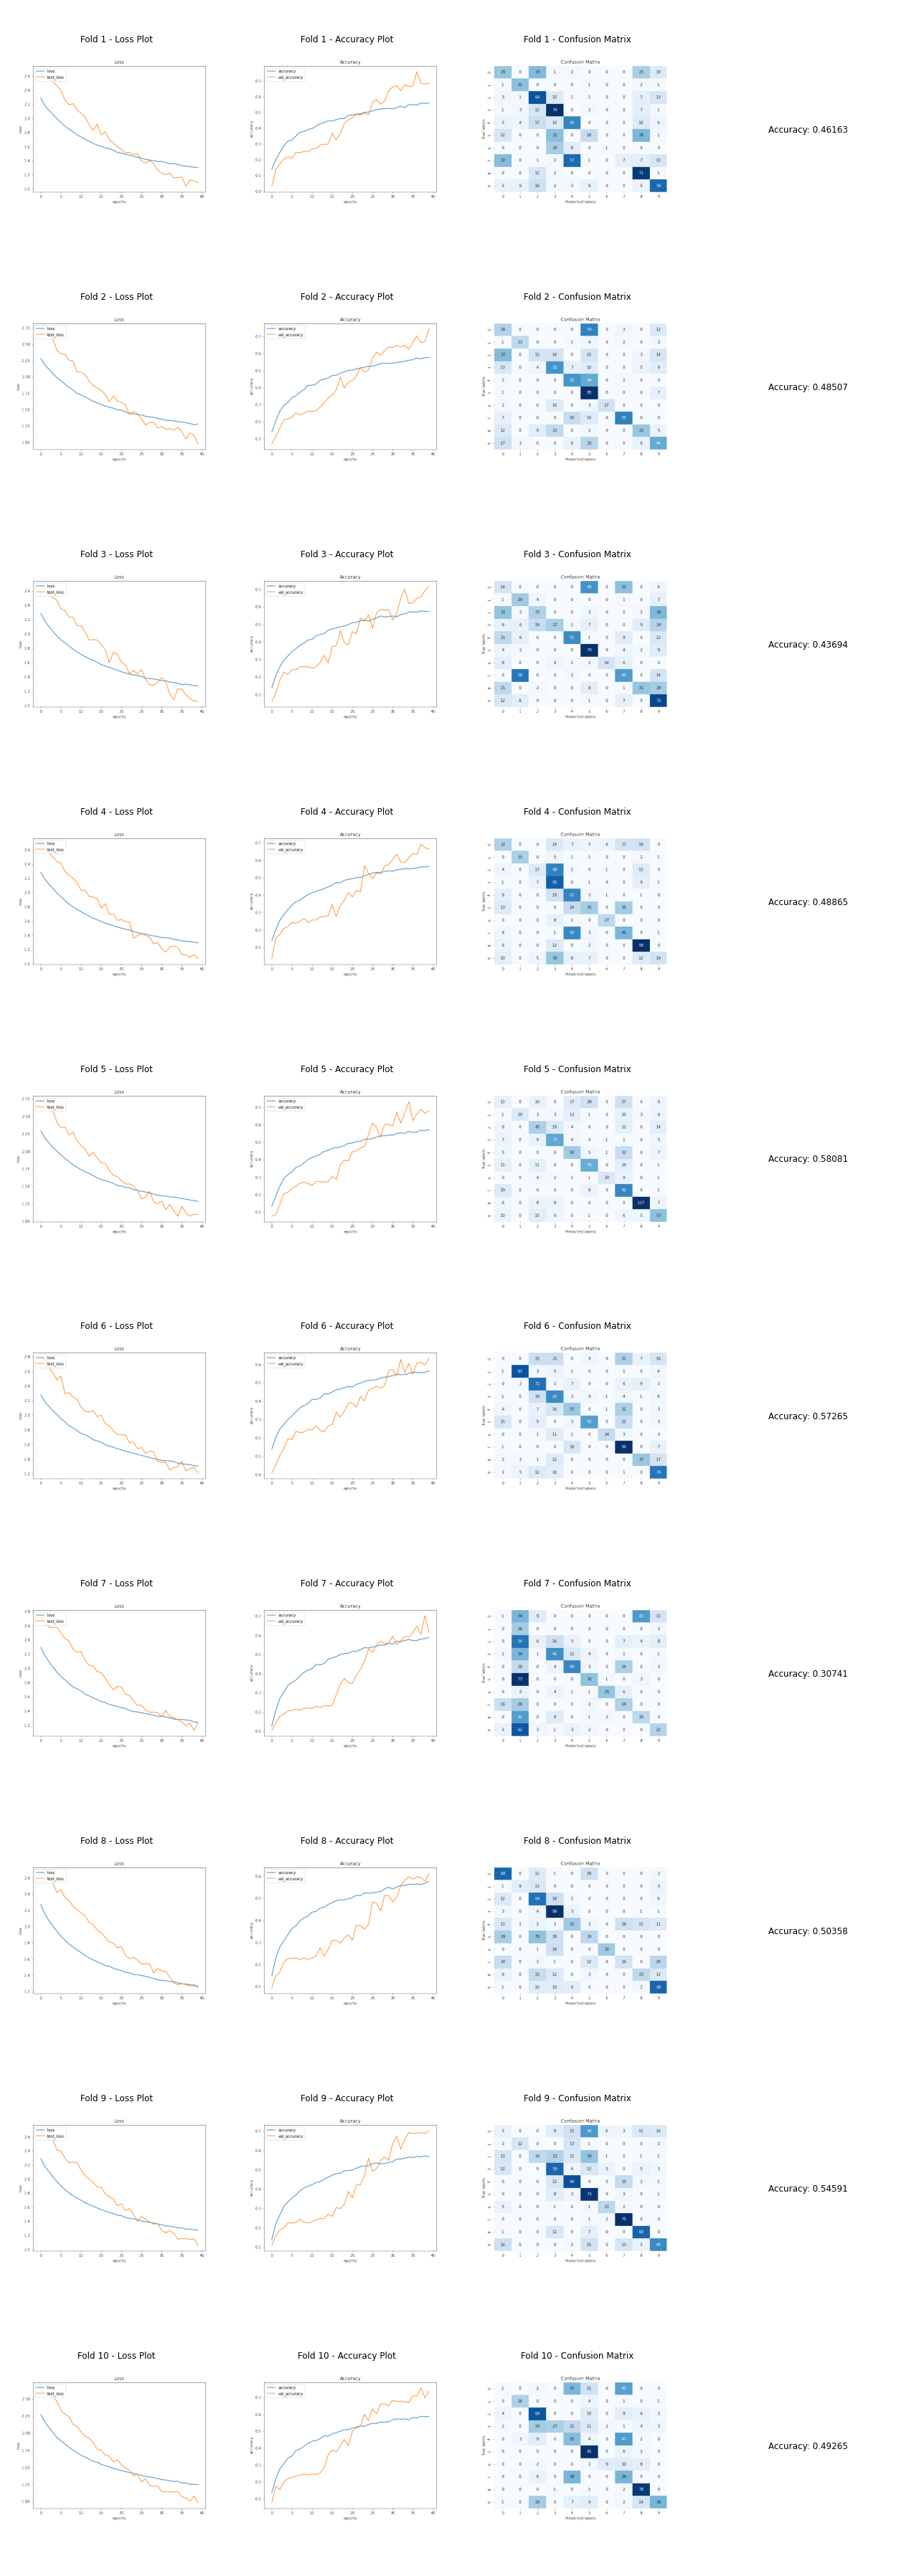

 
Accuracy média: 0.48753 (48.75%)
Desvio padrão médio: 0.07438 (7.44%)


In [89]:
import matplotlib.image as mpimg

# Número de folds
num_folds = 10

# Configurar a disposição dos subplots
fig, axs = plt.subplots(num_folds, 4, figsize=(18, 5*num_folds))

for i in range(num_folds):
    axs[i, 0].imshow(mpimg.imread(f'mlp_lossplotfold{i+1}.png'))
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Fold {i+1} - Loss Plot')

    axs[i, 1].imshow(mpimg.imread(f'mlp_accplotfold{i+1}.png'))
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Fold {i+1} - Accuracy Plot')

    axs[i, 2].imshow(mpimg.imread(f'mlp_cmfold{i+1}.png'))
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Fold {i+1} - Confusion Matrix')

    axs[i, 3].text(0.5, 0.5, f'Accuracy: {scores[i]:.5f}', fontsize=12, ha='center', va='center')
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

media = np.mean(scores)
desvio_padrao = np.std(scores)
print(" ")
print(f"Accuracy média: {media:.5f} ({media*100:.2f}%)")
print(f"Desvio padrão médio: {desvio_padrao:.5f} ({desvio_padrao*100:.2f}%)")

# CNN

### Implementação da rede neuronal usando o tensorflow

In [90]:
def CNN(X_train, y_train, X_test, y_test, loss_plot=None, cmatrix=None, acc_plot=None):
    
    # Assuming X_train and X_test are 2D arrays
    input_shape = X_train.shape[1:]  # Shape of each input sample

    # One-hot encode the labels (assuming y_train and y_test are class labels)
    num_classes = len(np.unique(y_train))
    
    # Ajuste o valor da learning rate conforme necessário
    learning_rate = 0.05
    
    # Crie um otimizador com a taxa de aprendizado desejada
    optimizer = SGD(learning_rate=learning_rate)

    # Build the CNN model
    model_cnn = Sequential()
    model_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_shape[0], 1)))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(num_classes, activation='softmax'))
    
    # Adicionar o Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile o modelo usando o otimizador personalizado
    model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model_cnn.fit(X_train, y_train, epochs=40, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

    # Make predictions on the test data
    y_pred = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Cálculo da accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Criação da confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Confusion Matrix
    if cmatrix:
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.savefig(cmatrix)
        plt.close()
    
    
    # plot training history for loss
    if loss_plot:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend(['loss','test_loss'], loc='upper left')
        plt.savefig(loss_plot)
        plt.close()
        
    # plot training history for accuracy
    if acc_plot:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend(['accuracy','val_accuracy'], loc='upper left')
        plt.savefig(acc_plot)
        plt.close()
        
    return accuracy,model_cnn

### Aplicação da Cross Validation 

In [91]:
n_folds=10
scores_cnn = []
for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            fold_file = f'C:/Users/andre/Documents/Faculdade/3ano_1sem/ACII/UrbanSound8K/audio/featuresfold{fold}.csv'
            features, labels = load_fold_data(fold_file)

            if fold == test_fold:
                X_test, y_test = features, labels
            else:
                X_train.append(features)
                y_train.append(labels)
                
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        smote = SMOTE(random_state = 42)
        
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
        # Nome do arquivo incorporando o índice do test_fold
        lossplot_filename = f'cnn_lossplotfold{test_fold}.png'
        
        # Nome do arquivo incorporando o índice do test_fold
        accplot_filename = f'cnn_accplotfold{test_fold}.png'
        
        # Nome do arquivo incorporando o índice do test_fold
        cmatrix_filename = f'cnn_cmfold{test_fold}.png'
   
        accuracy_cnn, model_cnn = CNN(X_resampled, y_resampled, X_test, y_test, loss_plot=lossplot_filename, cmatrix = cmatrix_filename, acc_plot = accplot_filename)
        scores_cnn.append(accuracy_cnn)
        

Epoch 1/40
64/64 [==============================] - 2s 16ms/step - loss: 2.2765 - accuracy: 0.1295 - val_loss: 2.7014 - val_accuracy: 0.0100
Epoch 2/40
64/64 [==============================] - 1s 10ms/step - loss: 2.2375 - accuracy: 0.1751 - val_loss: 2.7677 - val_accuracy: 0.0387
Epoch 3/40
64/64 [==============================] - 1s 10ms/step - loss: 2.1995 - accuracy: 0.2107 - val_loss: 2.7020 - val_accuracy: 0.0896
Epoch 4/40
64/64 [==============================] - 1s 10ms/step - loss: 2.1279 - accuracy: 0.2549 - val_loss: 2.6265 - val_accuracy: 0.1582
Epoch 5/40
64/64 [==============================] - 1s 10ms/step - loss: 2.0413 - accuracy: 0.2909 - val_loss: 2.4836 - val_accuracy: 0.1726
Epoch 6/40
64/64 [==============================] - 1s 10ms/step - loss: 1.9514 - accuracy: 0.3251 - val_loss: 2.3497 - val_accuracy: 0.2190
Epoch 7/40
64/64 [==============================] - 1s 10ms/step - loss: 1.8727 - accuracy: 0.3469 - val_loss: 2.3319 - val_accuracy: 0.1969
Epoch 8/40
64

64/64 [==============================] - 1s 10ms/step - loss: 1.3470 - accuracy: 0.5411 - val_loss: 1.1763 - val_accuracy: 0.6097
Epoch 19/40
64/64 [==============================] - 1s 10ms/step - loss: 1.3074 - accuracy: 0.5505 - val_loss: 1.3399 - val_accuracy: 0.5138
Epoch 20/40
64/64 [==============================] - 1s 10ms/step - loss: 1.2866 - accuracy: 0.5635 - val_loss: 1.2215 - val_accuracy: 0.5645
Epoch 21/40
64/64 [==============================] - 1s 10ms/step - loss: 1.2751 - accuracy: 0.5644 - val_loss: 1.1322 - val_accuracy: 0.6979
Epoch 22/40
64/64 [==============================] - 1s 10ms/step - loss: 1.2496 - accuracy: 0.5706 - val_loss: 0.9941 - val_accuracy: 0.7552
Epoch 23/40
64/64 [==============================] - 1s 10ms/step - loss: 1.2191 - accuracy: 0.5852 - val_loss: 1.0589 - val_accuracy: 0.6891
Epoch 24/40
64/64 [==============================] - 1s 10ms/step - loss: 1.2013 - accuracy: 0.5924 - val_loss: 0.9695 - val_accuracy: 0.7001
Epoch 25/40
64/64 

64/64 [==============================] - 1s 10ms/step - loss: 1.0529 - accuracy: 0.6437 - val_loss: 0.9578 - val_accuracy: 0.7333
Epoch 36/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0371 - accuracy: 0.6554 - val_loss: 0.7390 - val_accuracy: 0.7922
Epoch 37/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0251 - accuracy: 0.6581 - val_loss: 0.7950 - val_accuracy: 0.7967
Epoch 38/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0025 - accuracy: 0.6688 - val_loss: 0.8085 - val_accuracy: 0.7867
Epoch 39/40
64/64 [==============================] - 1s 10ms/step - loss: 0.9914 - accuracy: 0.6702 - val_loss: 0.7059 - val_accuracy: 0.8333
Epoch 40/40
28/28 [==============================] - 0s 3ms/step
Epoch 1/40
64/64 [==============================] - 2s 15ms/step - loss: 2.2804 - accuracy: 0.1275 - val_loss: 2.6712 - val_accuracy: 0.0156
Epoch 2/40
64/64 [==============================] - 1s 10ms/step - loss: 2.2452 - accuracy: 0.16

64/64 [==============================] - 1s 10ms/step - loss: 1.5753 - accuracy: 0.4551 - val_loss: 1.6894 - val_accuracy: 0.2933
Epoch 13/40
64/64 [==============================] - 1s 10ms/step - loss: 1.5364 - accuracy: 0.4693 - val_loss: 1.6869 - val_accuracy: 0.3000
Epoch 14/40
64/64 [==============================] - 1s 10ms/step - loss: 1.4912 - accuracy: 0.4878 - val_loss: 1.6457 - val_accuracy: 0.3489
Epoch 15/40
64/64 [==============================] - 1s 10ms/step - loss: 1.4530 - accuracy: 0.5035 - val_loss: 1.4477 - val_accuracy: 0.4900
Epoch 16/40
64/64 [==============================] - 1s 10ms/step - loss: 1.4189 - accuracy: 0.5177 - val_loss: 1.5265 - val_accuracy: 0.4711
Epoch 17/40
64/64 [==============================] - 1s 10ms/step - loss: 1.3940 - accuracy: 0.5219 - val_loss: 1.4219 - val_accuracy: 0.5200
Epoch 18/40
64/64 [==============================] - 1s 10ms/step - loss: 1.3796 - accuracy: 0.5279 - val_loss: 1.2937 - val_accuracy: 0.5011
Epoch 19/40
64/64 

64/64 [==============================] - 1s 10ms/step - loss: 1.0916 - accuracy: 0.6364 - val_loss: 0.8810 - val_accuracy: 0.7622
Epoch 30/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0738 - accuracy: 0.6411 - val_loss: 1.0642 - val_accuracy: 0.6967
Epoch 31/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0620 - accuracy: 0.6435 - val_loss: 0.5881 - val_accuracy: 0.8756
Epoch 32/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0337 - accuracy: 0.6616 - val_loss: 0.7448 - val_accuracy: 0.8211
Epoch 33/40
64/64 [==============================] - 1s 10ms/step - loss: 1.0221 - accuracy: 0.6577 - val_loss: 0.5937 - val_accuracy: 0.8633
Epoch 34/40
64/64 [==============================] - 1s 11ms/step - loss: 1.0018 - accuracy: 0.6706 - val_loss: 0.6609 - val_accuracy: 0.8467
Epoch 35/40
64/64 [==============================] - 1s 10ms/step - loss: 0.9890 - accuracy: 0.6735 - val_loss: 0.7068 - val_accuracy: 0.8067
Epoch 36/40
64/64 

65/65 [==============================] - 1s 10ms/step - loss: 2.0207 - accuracy: 0.3042 - val_loss: 2.4895 - val_accuracy: 0.2078
Epoch 7/40
65/65 [==============================] - 1s 10ms/step - loss: 1.9170 - accuracy: 0.3431 - val_loss: 2.4437 - val_accuracy: 0.2110
Epoch 8/40
65/65 [==============================] - 1s 10ms/step - loss: 1.8221 - accuracy: 0.3825 - val_loss: 2.3995 - val_accuracy: 0.2067
Epoch 9/40
65/65 [==============================] - 1s 10ms/step - loss: 1.7349 - accuracy: 0.4021 - val_loss: 2.2037 - val_accuracy: 0.2056
Epoch 10/40
65/65 [==============================] - 1s 10ms/step - loss: 1.6695 - accuracy: 0.4274 - val_loss: 2.1996 - val_accuracy: 0.2284
Epoch 11/40
65/65 [==============================] - 1s 10ms/step - loss: 1.6082 - accuracy: 0.4443 - val_loss: 2.1779 - val_accuracy: 0.2132
Epoch 12/40
65/65 [==============================] - 1s 10ms/step - loss: 1.5629 - accuracy: 0.4562 - val_loss: 1.9975 - val_accuracy: 0.2154
Epoch 13/40
65/65 [==

65/65 [==============================] - 1s 10ms/step - loss: 1.2921 - accuracy: 0.5635 - val_loss: 1.0370 - val_accuracy: 0.7180
Epoch 24/40
65/65 [==============================] - 1s 10ms/step - loss: 1.2648 - accuracy: 0.5682 - val_loss: 1.1119 - val_accuracy: 0.6182
Epoch 25/40
65/65 [==============================] - 1s 10ms/step - loss: 1.2415 - accuracy: 0.5854 - val_loss: 0.9841 - val_accuracy: 0.6963
Epoch 26/40
65/65 [==============================] - 1s 10ms/step - loss: 1.2139 - accuracy: 0.5885 - val_loss: 1.0096 - val_accuracy: 0.7636
Epoch 27/40
65/65 [==============================] - 1s 10ms/step - loss: 1.1950 - accuracy: 0.5991 - val_loss: 0.7749 - val_accuracy: 0.8297
Epoch 28/40
65/65 [==============================] - 1s 10ms/step - loss: 1.1763 - accuracy: 0.6020 - val_loss: 0.7937 - val_accuracy: 0.8210
Epoch 29/40
65/65 [==============================] - 1s 10ms/step - loss: 1.1479 - accuracy: 0.6151 - val_loss: 0.7615 - val_accuracy: 0.8406
Epoch 30/40
65/65 

26/26 [==============================] - 0s 3ms/step


In [92]:
model_cnn.summary()

Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 52, 32)            128       
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 26, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_122 (Flatten)       (None, 832)               0         
                                                                 
 dense_244 (Dense)           (None, 128)               106624    
                                                                 
 dropout_122 (Dropout)       (None, 128)               0         
                                                                 
 dense_245 (Dense)           (None, 10)                1290      
                                                    

### Resultados da Cross Validation 

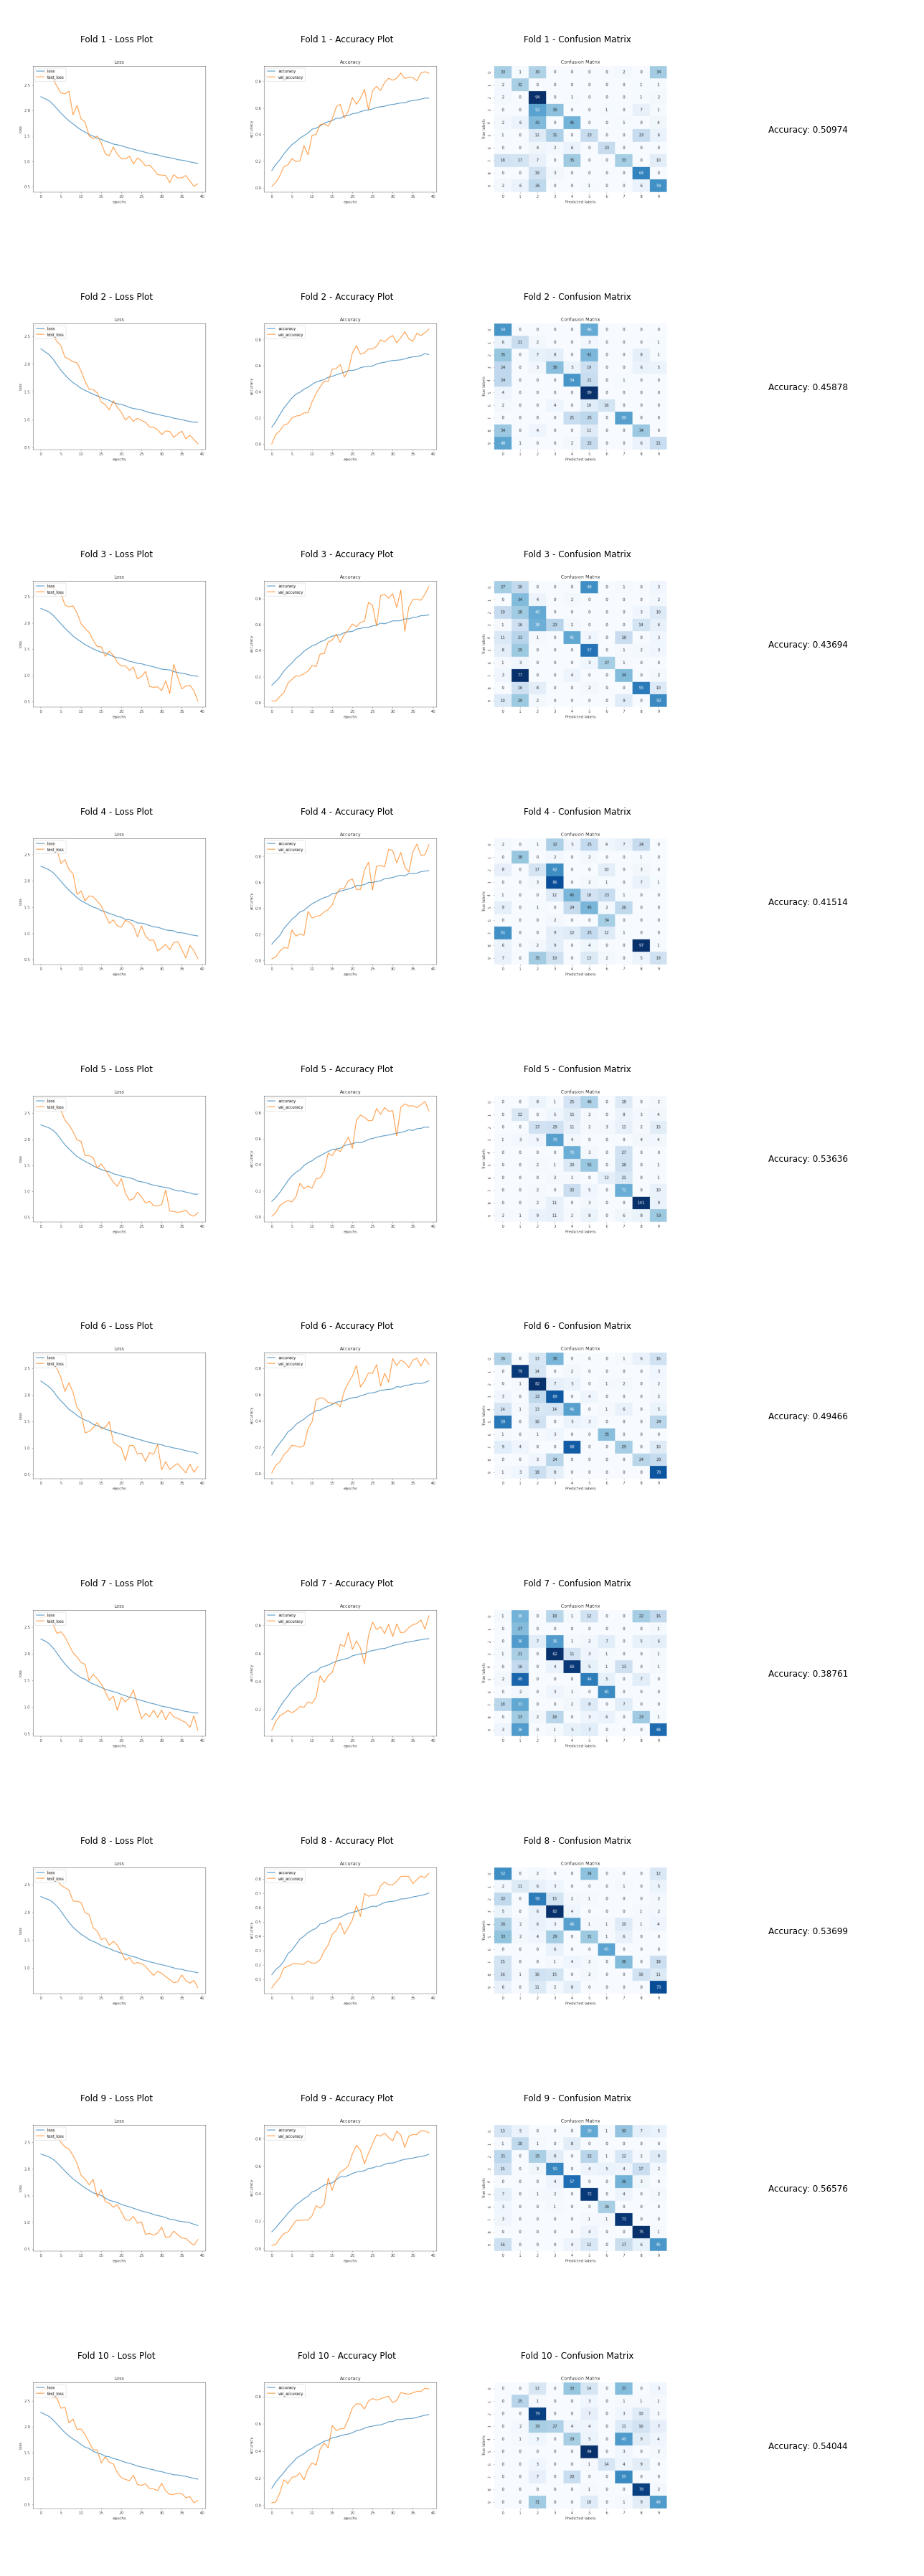

 
Accuracy média: 0.48824 (48.82%)
Desvio padrão médio: 0.05736 (5.74%)


In [93]:
import matplotlib.image as mpimg

# Número de folds
num_folds = 10

# Configurar a disposição dos subplots
fig, axs = plt.subplots(num_folds, 4, figsize=(18, 5*num_folds))

for i in range(num_folds):
    axs[i, 0].imshow(mpimg.imread(f'cnn_lossplotfold{i+1}.png'))
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Fold {i+1} - Loss Plot')

    axs[i, 1].imshow(mpimg.imread(f'cnn_accplotfold{i+1}.png'))
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Fold {i+1} - Accuracy Plot')

    axs[i, 2].imshow(mpimg.imread(f'cnn_cmfold{i+1}.png'))
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Fold {i+1} - Confusion Matrix')

    axs[i, 3].text(0.5, 0.5, f'Accuracy: {scores_cnn[i]:.5f}', fontsize=12, ha='center', va='center')
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

media = np.mean(scores_cnn)
desvio_padrao = np.std(scores_cnn)
print(" ")
print(f"Accuracy média: {media:.5f} ({media*100:.2f}%)")
print(f"Desvio padrão médio: {desvio_padrao:.5f} ({desvio_padrao*100:.2f}%)")